In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from PIL import Image


from google.colab import drive
drive.mount('/content/drive')

%cd "drive/Shareddrives/DL_Project/"

image_path = "car_data/all_images/"
training_split = 0.8
validation_split = 0.1
# testing_split = 0.1
device = torch.device("cuda" if torch.cuda.is_available()else"cpu")


Mounted at /content/drive
/content/drive/Shareddrives/DL_Project


In [2]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 9.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Yolo model for detecting cars/trucks in order to crop them later

In [3]:
from ultralytics import YOLO
import matplotlib.patches as patches

model = YOLO("yolov8n.pt")

def get_surface(box):
    x1, y1, x2, y2 = box
    return (x2-x1)*(y2-y1)

def get_box(image_name):
  results = model(image_name)
  boxes = results[0].boxes.xyxy.tolist()
  classes = results[0].boxes.cls.tolist()
  names = results[0].names
  confidences = results[0].boxes.conf.tolist()

  box_biggest_car = None
  biggest_surface = 0

  # Iterate through the results
  for box, cls, conf in zip(boxes, classes, confidences):
    class_name = names[int(cls)]

    if class_name == "car" or class_name == "truck":
      s = get_surface(box)
      if s > biggest_surface:
        biggest_surface = s
        box_biggest_car = box
  return box_biggest_car


### Example


image 1/1 /content/drive/Shareddrives/DL_Project/car_data/all_images/11283.jpg: 448x640 1 truck, 71.5ms
Speed: 19.2ms preprocess, 71.5ms inference, 737.6ms postprocess per image at shape (1, 3, 448, 640)


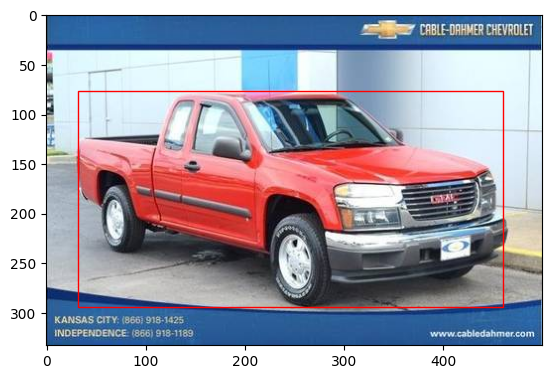

In [ ]:
# Load a model

img= image_path + "11283.jpg"
image = Image.open(img)
fig, ax = plt.subplots(1)
ax.imshow(image)
x1, y1, x2, y2 = get_box(img)
rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(rect)

# Display the plot
plt.show()

# Preprocessing

In [3]:
df = pd.read_excel("annotations.xlsx")
df.head()

,image_name,x1,y1,x2,y2,label,price,name
0,00001.jpg,39,116,569,375,13,48000,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,2,36000,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,90,23000,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,133,25850,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,105,50000,Ford F-450 Super Duty Crew Cab 2012


### Visualization of a car using data augmentation

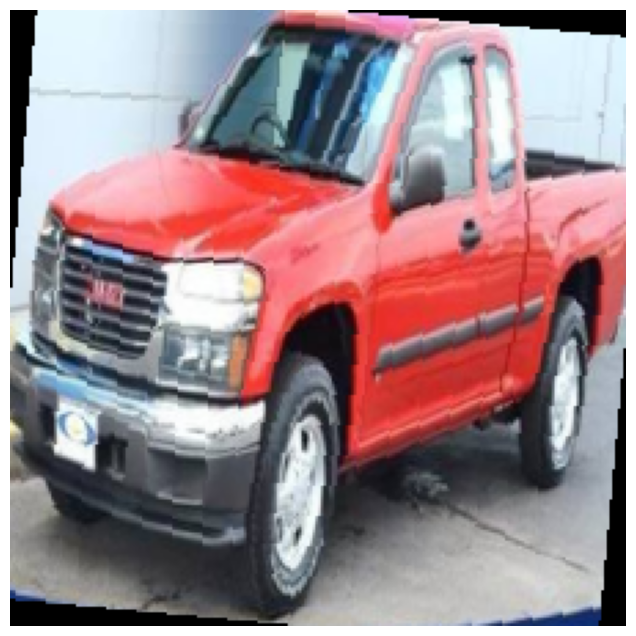

In [4]:
import torchvision.transforms as transforms
row = df.iloc[11282]
img_name = image_path + row["image_name"]
image = Image.open(img_name).convert('RGB')

# print(image.s)
crop_box = (row["x1"],row["y1"],row["x2"],row["y2"])
image = image.crop(crop_box)
# image = TF.rotate(image, 15)
train_tf = transforms.Compose([ transforms.Resize((224,224)),
                                transforms.RandomRotation((0,10)),
                                transforms.RandomHorizontalFlip()
                                ])

image = train_tf(image)


# Display the cropped image using matplotlib
plt.figure(figsize=(8, 8))  # You can adjust the size as needed
plt.imshow(image)
plt.axis('off')  # Turn off the axis labels
plt.show()

In [5]:
df.label.value_counts()

label
118    136
78      97
160     96
166     95
143     93
      ... 
174     61
63      59
157     58
98      55
135     48
Name: count, Length: 196, dtype: int64

## Split

In [4]:
train_df, temp_df = train_test_split(df, train_size=training_split, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=validation_split/(1-training_split), stratify=temp_df['label'], random_state=42)

print(validation_split/(1-training_split))

0.5000000000000001


In [5]:
test_df.head()

,image_name,x1,y1,x2,y2,label,price,name
11282,11283.jpg,31,79,468,296,121,23285,GMC Canyon Extended Cab 2012
3780,03781.jpg,66,43,478,371,195,8000,smart fortwo Convertible 2012
7338,07339.jpg,106,187,509,406,23,47000,Audi S4 Sedan 2007
10010,10011.jpg,25,18,298,218,34,85700,BMW M5 Sedan 2010
4950,04951.jpg,57,199,982,675,43,170000,Bentley Continental Flying Spur Sedan 2007


In [6]:
num_classes = df.label.nunique()
count = df.label.value_counts()

print(f'the total number of classes is {num_classes}')
print(f'the total number of images in Training dataset is {len(df)*training_split}')
print(f'the total number of images in Validation dataset is {len(val_df)}')
print(f'the total number of images in Testing dataset is {len(test_df)}')
print(f'the minimum of images we can get is {count.min()} for the class {count[count == count.min()].index.tolist()[0]}')
print(f'the minimum of images we can get is {count.max()} for the class {count[count == count.max()].index.tolist()[0]}')
print(f'the average number of image per class is {int(count.mean())}')

the total number of classes is 196
the total number of images in Training dataset is 12948.0
the total number of images in Validation dataset is 1618
the total number of images in Testing dataset is 1619
the minimum of images we can get is 48 for the class 135
the minimum of images we can get is 136 for the class 118
the average number of image per class is 82


## Transformation

In [7]:
# # #transformation for VGG
# train_tf = transforms.Compose([ transforms.Resize((224,224)),
#                                 transforms.RandomRotation((0,10)),
#                                 transforms.RandomHorizontalFlip(),
#                                 transforms.ColorJitter(brightness=0.2, contrast=0.2),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                 ])
# test_tf = transforms.Compose([transforms.Resize((224,224)),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [8]:
# transform for Resnet
train_tf = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tf = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## The model

### Resnet50

In [9]:
import torchvision.models as models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class MyResNet50(nn.Module):
  def __init__(self, num_classes= 196, unfreeze_flag= True):
    super().__init__()
    resnet50_model = models.resnet50(pretrained=True)
    self.resnet50_model = resnet50_model
    #freezen network
    for param in self.resnet50_model.parameters():
      param.require_grad = unfreeze_flag

    self.resnet50_model.fc = nn.Linear(2048, 196)
    self.resnet50_model.fc.apply(weights_init)
  def forward(self,x):
    out = self.resnet50_model(x)

    return out


model = MyResNet50()
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


### VGG

In [10]:
import torchvision.models as models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class MyVGG(nn.Module):
  def __init__(self,num_class=196, unfreeze_flag = True):
    super().__init__()
    self.vgg_model = models.vgg16(pretrained=True)
    # unfreeze / freeze parameters
    for param in self.vgg_model.parameters():
      param.require_grad =  unfreeze_flag
    # replace the last layer
    self.vgg_model.classifier[6]= nn.Linear(4096,num_class)
    # using initialize weight strategy
    self.vgg_model.classifier[6].apply(weights_init)

  def forward(self, x):
    return self.vgg_model(x)

# model = MyVGG()
# model = model.to(device)

### Training and evaluation functions

In [11]:
from tqdm import tqdm  # for nice progress bars


def train_model(model, train_loader,val_loader, loss_fn, optimizer, scheduler, epochs=10):
    model.to(device)
    epoch_stats = []
    previous_lr = get_lr(optimizer)
    print("Initial Learning Rate: ", previous_lr)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels,_ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients on each batch
            outputs = model(images)  # Generate predictions
            loss = loss_fn(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the weights

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            val_loss, val_correct, val_total = 0, 0, 0
            for images, labels,_ in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc =  val_correct / val_total
        # Collect statistics for the current epoch
        epoch_stats.append({
            'epoch': epoch + 1,
            'train_loss': train_loss / train_total,
            'train_accuracy': train_correct / train_total * 100,
            'val_loss': val_loss / val_total,
            'val_accuracy': val_acc * 100
        })

        # re-set the model to train mode after validating
        model.train()

        # Print statistics
        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss / train_total:.4f}, Train Acc: {train_correct / train_total * 100:.2f}%')
        print(f'Val Loss: {val_loss / val_total:.4f}, Val Acc: {val_correct / val_total * 100:.2f}%')
        scheduler.step(val_acc)
        current_lr = get_lr(optimizer)

        if current_lr != previous_lr:
          print(f"Learning Rate changed at epoch {epoch + 1}: {current_lr}")
          previous_lr = current_lr

    return epoch_stats

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from torch import no_grad
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, test_loader):
    model.to(device)
    print(device)
    model.eval()

    all_preds = []
    all_labels = []

    with no_grad():
        # for images, labels,_ in test_loader:
        for images, labels,_ in tqdm(test_loader):

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            # Collect all predictions and labels

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate and print classification report
    print(classification_report(all_labels, all_preds))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # print("Confusion Matrix:")
    # print(cm)

    # # Plotting the confusion matrix
    # plt.figure(figsize=(10, 7))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title('Confusion Matrix')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.show()

    return all_preds, all_labels,cm

In [13]:
import torch.optim as optim
lr = 1e-2
momentum = 0.9
batch_size = 32
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, threshold=0.9)

In [14]:
from torch import tensor
class CarDataset(Dataset):
  def __init__(self, df, transform = None,for_training = True):
    self.dataframe = df
    self.transform = transform
    self.for_training = for_training

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    row = self.dataframe.iloc[idx]
    img_name = image_path + row["image_name"]
    image = Image.open(img_name).convert('RGB')

    if self.for_training:
      crop_box = (row["x1"],row["y1"],row["x2"],row["y2"])
      image = image.crop(crop_box)

    if self.transform:
      image = self.transform(image)

    label = self.dataframe.iloc[idx]["label"]
    price = self.dataframe.iloc[idx]["price"]

    label = tensor(label,dtype= torch.long)
    price = tensor(price,dtype= torch.float)
    return image, label, img_name

In [15]:
train_ds = CarDataset(train_df,train_tf)
val_ds = CarDataset(val_df, test_tf)
test_ds = CarDataset(test_df,test_tf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Training

In [ ]:
#####
# Training

epochs_stats = train_model(model, train_loader,val_loader, loss_fn, optimizer,lrscheduler, epochs=epochs)


Initial Learning Rate:  0.01


Epoch 1/20: 100%|██████████| 405/405 [03:40<00:00,  1.84batch/s]


Epoch 1:
Train Loss: 4.9947, Train Acc: 2.82%
Val Loss: 3.8884, Val Acc: 11.87%


Epoch 2/20: 100%|██████████| 405/405 [03:36<00:00,  1.87batch/s]


Epoch 2:
Train Loss: 3.0778, Train Acc: 24.68%
Val Loss: 2.1014, Val Acc: 43.39%


Epoch 3/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 3:
Train Loss: 1.8821, Train Acc: 48.68%
Val Loss: 1.4343, Val Acc: 59.58%


Epoch 4/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 4:
Train Loss: 1.2984, Train Acc: 63.16%
Val Loss: 1.0831, Val Acc: 68.79%


Epoch 5/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 5:
Train Loss: 0.9569, Train Acc: 72.12%
Val Loss: 0.9368, Val Acc: 74.29%
Learning Rate changed at epoch 5: 0.001


Epoch 6/20: 100%|██████████| 405/405 [03:33<00:00,  1.90batch/s]


Epoch 6:
Train Loss: 0.3962, Train Acc: 87.67%
Val Loss: 0.4643, Val Acc: 86.96%


Epoch 7/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 7:
Train Loss: 0.2694, Train Acc: 91.53%
Val Loss: 0.4462, Val Acc: 87.33%


Epoch 8/20: 100%|██████████| 405/405 [03:36<00:00,  1.87batch/s]


Epoch 8:
Train Loss: 0.2281, Train Acc: 92.47%
Val Loss: 0.4191, Val Acc: 87.64%


Epoch 9/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 9:
Train Loss: 0.1977, Train Acc: 93.31%
Val Loss: 0.4168, Val Acc: 88.69%
Learning Rate changed at epoch 9: 0.0001


Epoch 10/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 10:
Train Loss: 0.1641, Train Acc: 94.37%
Val Loss: 0.4064, Val Acc: 88.81%


Epoch 11/20: 100%|██████████| 405/405 [03:35<00:00,  1.88batch/s]


Epoch 11:
Train Loss: 0.1544, Train Acc: 94.62%
Val Loss: 0.4026, Val Acc: 89.00%


Epoch 12/20: 100%|██████████| 405/405 [03:35<00:00,  1.88batch/s]


Epoch 12:
Train Loss: 0.1512, Train Acc: 94.83%
Val Loss: 0.4031, Val Acc: 89.00%
Learning Rate changed at epoch 12: 1e-05


Epoch 13/20: 100%|██████████| 405/405 [03:39<00:00,  1.85batch/s]


Epoch 13:
Train Loss: 0.1500, Train Acc: 94.89%
Val Loss: 0.4035, Val Acc: 89.00%


Epoch 14/20: 100%|██████████| 405/405 [03:38<00:00,  1.86batch/s]


Epoch 14:
Train Loss: 0.1536, Train Acc: 95.06%
Val Loss: 0.4030, Val Acc: 89.06%


Epoch 15/20: 100%|██████████| 405/405 [03:37<00:00,  1.87batch/s]


Epoch 15:
Train Loss: 0.1493, Train Acc: 94.98%
Val Loss: 0.4031, Val Acc: 89.12%
Learning Rate changed at epoch 15: 1.0000000000000002e-06


Epoch 16/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 16:
Train Loss: 0.1457, Train Acc: 95.13%
Val Loss: 0.4032, Val Acc: 89.12%


Epoch 17/20: 100%|██████████| 405/405 [03:35<00:00,  1.88batch/s]


Epoch 17:
Train Loss: 0.1475, Train Acc: 95.16%
Val Loss: 0.4032, Val Acc: 89.12%


Epoch 18/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 18:
Train Loss: 0.1464, Train Acc: 95.21%
Val Loss: 0.4032, Val Acc: 89.12%
Learning Rate changed at epoch 18: 1.0000000000000002e-07


Epoch 19/20: 100%|██████████| 405/405 [03:34<00:00,  1.89batch/s]


Epoch 19:
Train Loss: 0.1451, Train Acc: 95.28%
Val Loss: 0.4032, Val Acc: 89.12%


Epoch 20/20: 100%|██████████| 405/405 [03:36<00:00,  1.87batch/s]


Epoch 20:
Train Loss: 0.1444, Train Acc: 95.01%
Val Loss: 0.4032, Val Acc: 89.12%


### Saving

In [ ]:
import torch

name_model = 'vaaaagg16_20_epochs_32_batch_size_01_06'
torch.save(model, name_model + '.pth')


In [ ]:
###################
# Evaluation

all_preds, all_labels = evaluate_model(model, test_loader, threashold = None)


              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       1.00      1.00      1.00         6
           2       0.89      0.89      0.89         9
           3       1.00      0.89      0.94         9
           4       0.89      1.00      0.94         8
           5       0.89      0.89      0.89         9
           6       1.00      0.88      0.93         8
           7       0.56      0.56      0.56         9
           8       0.83      0.62      0.71         8
           9       0.83      0.83      0.83         6
          10       0.71      0.71      0.71         7
          11       1.00      0.86      0.92         7
          12       0.73      0.89      0.80         9
          13       0.71      0.56      0.63         9
          14       0.90      1.00      0.95         9
          15       0.78      0.88      0.82         8
          16       0.75      0.75      0.75         8
          17       0.60    

this was the training of vgg16

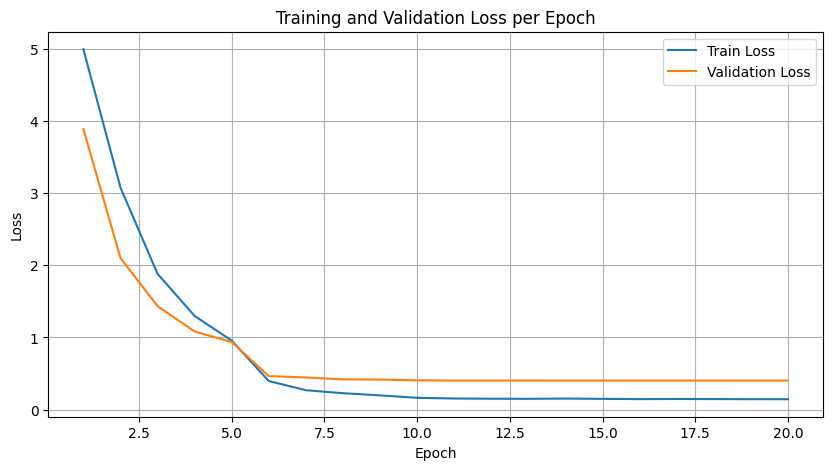

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
train_losses = [entry['train_loss'] for entry in epochs_stats]
val_losses = [entry['val_loss'] for entry in epochs_stats]
epochs = [entry['epoch'] for entry in epochs_stats]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig( name_model + '.png', format='png', dpi=300, bbox_inches='tight', transparent=True)



# Evaluation of the results and the prices

In [16]:
## With GPU
# loaded_model = torch.load('vgg16_20_epochs_32_batch_size_01_06.pth')
loaded_model = torch.load('resnet50_15_epochs_32_batch_size.pth')

## Without GPU
# loaded_model = torch.load('vgg16_20_epochs_32_batch_size_01_06.pth', map_location=torch.device('cpu'))
# loaded_model = torch.load('resnet50_15_epochs_32_batch_size.pth', map_location=torch.device('cpu'))

In [24]:
all_preds, all_labels,cm = evaluate_model(loaded_model, test_loader)


cuda


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 51/51 [00:30<00:00,  1.67it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.86      1.00      0.92         6
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00         9
           4       1.00      0.88      0.93         8
           5       0.90      1.00      0.95         9
           6       1.00      0.88      0.93         8
           7       1.00      0.89      0.94         9
           8       0.75      0.75      0.75         8
           9       1.00      1.00      1.00         6
          10       0.67      0.57      0.62         7
          11       1.00      0.86      0.92         7
          12       0.80      0.89      0.84         9
          13       0.67      0.44      0.53         9
          14       1.00      1.00      1.00         9
          15       0.86      0.75      0.80         8
          16       0.73      1.00      0.84         8
          17       1.00    

In [17]:
df_price = df.groupby('label')['price'].first()

df_price.head()

label
0    70000
1    48000
2    36000
3    39000
4    31000
Name: price, dtype: int64

In [25]:
import torch.nn.functional as F

def get_price(label):
  return df_price[label]

prices = [get_price(label) for label in range(196)]
# print(prices)


#Transformation for Vgg16
# test_tf = transforms.Compose([transforms.Resize((224, 224)),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Transformation for ResNet50
test_tf = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

top_k = 5
threshold = [5,10,20,50] #%
index = 100

def get_price_threshold (predicted_probabilities,predicted_prices,threshold):
    predicted_probabilities_2 = [prob for prob in predicted_probabilities if prob >threshold]
    total_prob = sum(predicted_probabilities_2)

    prices_threshold = [p/total_prob * price for p,price in zip(predicted_probabilities_2,predicted_prices)]
    price_threshold = int(sum(prices_threshold))
    return price_threshold

def analyse_price(index,df,top_k,thresholds,show_results =False):

  row = df.iloc[index]
  img_name = image_path + row["image_name"]
  image = Image.open(img_name).convert('RGB')

  crop_box = (row["x1"],row["y1"],row["x2"],row["y2"])
  image = image.crop(crop_box)

  image = test_tf(image)
  original_label = row["label"]

  image = image.unsqueeze(0).to(device)  # Add a batch dimension

  outputs = loaded_model(image)

  probabilities = F.softmax(outputs, dim=1)
  s = 0
  for i in range(196):
    s+= probabilities[0,i]*prices[i]

  probabilities = probabilities.detach()
  probabilities = np.array(probabilities[0].cpu())

  top_values, top_indices = torch.topk(outputs.data, top_k)
  top_values = np.array(top_values[0].cpu())
  top_indices = np.array(top_indices[0].cpu())

  predicted_prices = [get_price(label) for label in top_indices]
  real_price = get_price(original_label)

  top_prediction = top_indices[0]
  top_confidence = probabilities[top_prediction]
  probabilities_top_k = np.array([probabilities[label] for label in top_indices])

  formatted_probabilities = [f"{prob * 100:.2f}%" for prob in probabilities_top_k]
  predicted_probabilities = [float(x[:-1]) for x in formatted_probabilities]

  weighted_price = int(s.item())




  res = [real_price,predicted_prices[0],  weighted_price]

  for thres in thresholds :
    res.append(get_price_threshold (predicted_probabilities,predicted_prices,thres))


  if show_results :
    print(f"original label : {original_label}")
    print(f"real price : {real_price} dollars")
    print(f"predicted price : {predicted_prices[0]} dollars with the confidence of {round(top_confidence*100,2)}%")
    print(" ")
    print(f"predicted price with probabilities weighting :{weighted_price}")
    print(" ")
    print(f"predicted top_{top_k} classes {top_indices}")
    # print(f"with these values {top_values}")
    print(f"predicted prices  {predicted_prices}")

    print(f"probabilities_top_{top_k} are {formatted_probabilities}")
    print(f"the final price with threshold {thresholds[0]} is {res[3]} dollars")
  return original_label,res

original_label, prices_res = analyse_price(index,test_df,top_k,threshold,show_results = True)



original label : 190
real price : 5000 dollars
predicted price : 5000 dollars with the confidence of 99.59%
 
predicted price with probabilities weighting :5077
 
predicted top_5 classes [190  47  84 171 180]
predicted prices  [5000, 31000, 20000, 3000, 5000]
probabilities_top_5 are ['99.59%', '0.13%', '0.06%', '0.05%', '0.03%']
the final price with threshold 5 is 5000 dollars


For the label 18, the confidence is lower than for other labels

In [27]:
original_label, prices_res = analyse_price(14586,df,top_k,threshold,show_results = True)


original label : 18
real price : 39000 dollars
predicted price : 39000 dollars with the confidence of 55.51%
 
predicted price with probabilities weighting :45874
 
predicted top_5 classes [ 18  24  13 140  21]
predicted prices  [39000, 57000, 48000, 50500, 53000]
probabilities_top_5 are ['55.51%', '22.69%', '15.74%', '2.89%', '1.95%']
the final price with threshold 5 is 44855 dollars


## Computing the prices for the testing dataset and save it

In [28]:
# price_per_label = [[] for i in range(196)]
# df_test = test_df.reset_index(drop=True)

# for i in range(len(df_test)):
#   print(i)
#   label, prices_res = analyse_price(i,df_test,top_k,threshold)
#   price_per_label[label].append(prices_res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


KeyboardInterrupt: 

In [ ]:
# #save the prices
# import pickle
# with open('prices_resnet_with_yolo_detection.pickle', 'wb') as f:
#     pickle.dump(price_per_label, f)

## Opening prices per label for the testing dataset

In [29]:
#ResNet50
with open('prices.pickle', 'rb') as f:
    price_per_label = pickle.load(f)


# #Vgg16
# with open('prices_vgg.pickle', 'rb') as f:
#     price_per_label = pickle.load(f)

# Afficher les données chargées
print(price_per_label)

[[[70000, 70000, 69999, 70000, 70000, 70000, 70000], [70000, 70000, 69986, 70000, 70000, 70000, 70000], [70000, 70000, 69135, 66433, 69113, 70000, 70000], [70000, 70000, 69848, 70000, 70000, 70000, 70000], [70000, 70000, 69959, 70000, 70000, 70000, 70000], [70000, 70000, 69999, 70000, 70000, 70000, 70000], [70000, 70000, 69969, 70000, 70000, 70000, 70000], [70000, 70000, 70143, 70000, 70000, 70000, 70000], [70000, 70000, 69451, 69463, 70000, 70000, 70000]], [[48000, 48000, 47899, 48000, 48000, 48000, 48000], [48000, 48000, 47904, 48000, 48000, 48000, 48000], [48000, 48000, 47967, 48000, 48000, 48000, 48000], [48000, 48000, 47986, 48000, 48000, 48000, 48000], [48000, 48000, 47987, 48000, 48000, 48000, 48000], [48000, 48000, 47983, 48000, 48000, 48000, 48000]], [[36000, 36000, 36034, 36000, 36000, 36000, 36000], [36000, 36000, 36017, 36000, 36000, 36000, 36000], [36000, 36000, 36074, 36000, 36000, 36000, 36000], [36000, 36000, 36144, 36000, 36000, 36000, 36000], [36000, 36000, 36890, 368

## Analyse the mean distances for each label

In [30]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r_squared(y_true, y_pred):
    correlation_matrix = np.corrcoef(y_true, y_pred)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared


In [31]:
def analyse_distances(distance):
  distances = [[] for i in range(196)]

  for label in range(196):
    list_prices = np.array(price_per_label[label])
    for k in range(1,len(list_prices[0])):
      distances[label].append(int(distance(list_prices[:,0],list_prices[:,k])))


  distances = np.array(distances)
  d = [np.mean(distances[:,k]) for k in range(6)]
  print(d)
  print(f"distance with the price of the highest prediction                      : {int(d[0])}")
  print(f"distance with the weighted price prediction                            : {int(d[1])}")
  print(f"distance with the price considering the threshold of 5% of confidence  : {int(d[2])}")
  print(f"distance with the price considering the threshold of 10% of confidence : {int(d[3])}")
  print(f"distance with the price considering the threshold of 20% of confidence : {int(d[4])}")
  print(f"distance with the price considering the threshold of 40% of confidence : {int(d[5])}")
  return d



In [32]:
distances = analyse_distances(mean_absolute_error)
#  res = [real_price,predicted_prices[0],  weighted_price,threshold_5,threshold_10,threshold_20,threshold_40]

[2909.7755102040815, 4795.275510204082, 3901.0408163265306, 3401.1530612244896, 3176.035714285714, 4490.280612244898]
distance with the price of the highest prediction                      : 2909
distance with the weighted price prediction                            : 4795
distance with the price considering the threshold of 5% of confidence  : 3901
distance with the price considering the threshold of 10% of confidence : 3401
distance with the price considering the threshold of 20% of confidence : 3176
distance with the price considering the threshold of 40% of confidence : 4490


# Some interesting plots for the final presentation

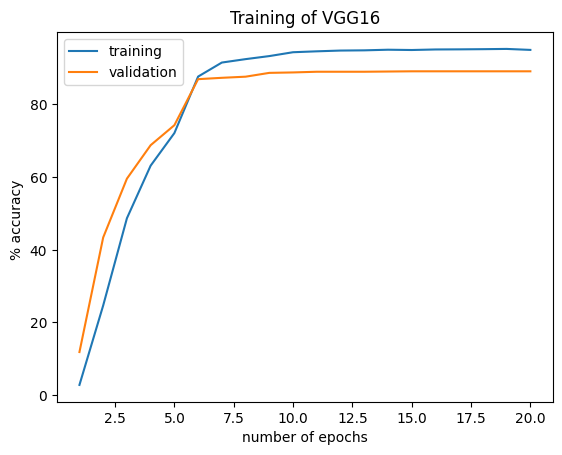

In [ ]:
import matplotlib.pyplot as plt
training_acc  = [2.82,24.68,48.68,63.16,72.12,87.67,91.53,92.47,93.31,94.37,94.62,94.83,94.89,95.06,94.98,95.13,95.16,95.21,95.28,95.01]
val_acc = [11.87,43.39,59.58,68.79,74.29,86.96,87.33,87.64,88.69,88.81,89.00,89.00,89.00,89.06,89.12,89.12,89.12,89.12,89.12,89.12]
x = [i for i in range(1,21)]
plt.plot(x,training_acc,label="training")
plt.plot(x,val_acc,label="validation")
plt.xlabel("number of epochs")
plt.ylabel("% accuracy ")
plt.title("Training of VGG16")
plt.legend()
plt.show()

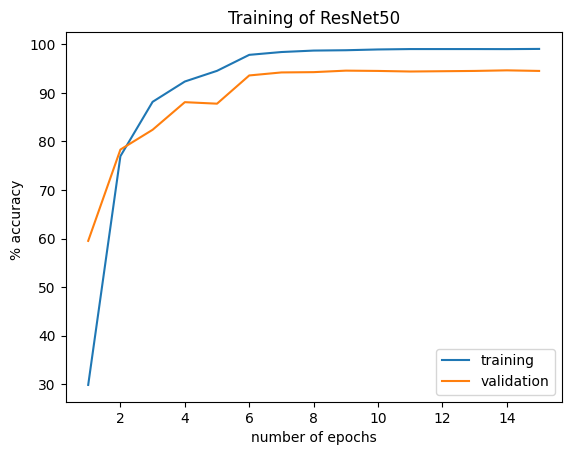

In [ ]:
import matplotlib.pyplot as plt
training_acc =[29.87,76.95,88.14,92.32,94.52,97.81,98.39,98.69,98.76,98.92,99.00,99.00,99.00,98.99,99.03]
val_acc = [59.52,78.31,82.39,88.07,87.76,93.57,94.19,94.25,94.56,94.50,94.38,94.44,94.50,94.62,94.50]
x = [i for i in range(1,16)]
plt.plot(x,training_acc,label="training")
plt.plot(x,val_acc,label="validation")
plt.xlabel("number of epochs")
plt.ylabel("% accuracy ")
plt.title("Training of ResNet50")
plt.legend()
plt.show()


category
0       8005.369852
1      13863.236696
2      18333.898104
3      22003.928571
4      24400.217092
5      26518.952618
6      28628.653676
7      33338.320790
8      36747.872454
9      40024.072356
10     48452.120641
11     59933.455218
12     89544.081081
13    172751.364841
14    651810.610352
Name: price, dtype: float64


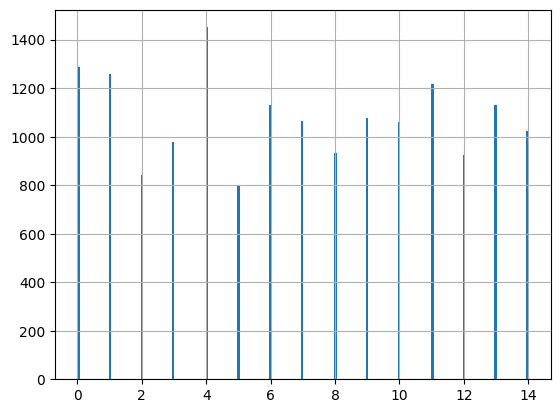

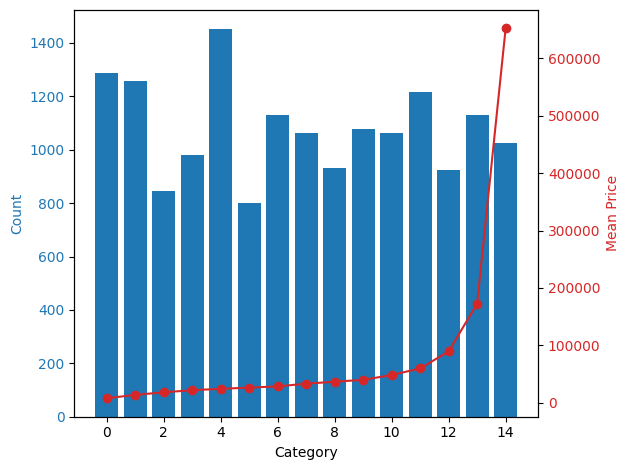

In [ ]:
num_categories = 15

# Use qcut to create quantile-based bins with numeric labels
df['category'] = pd.qcut(df['price'], q=num_categories, labels=[i for i in range(num_categories)])

df_prices = df['category']
df_prices.hist(bins=200)

mean_prices_per_category = df.groupby('category')['price'].mean()

print(mean_prices_per_category)


summary = df.groupby('category')['price'].agg(['mean', 'count'])

# Creating the plot
fig, ax1 = plt.subplots()

# Bar plot for the count of items
color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Count', color=color)
ax1.bar(summary.index, summary['count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Twin axis for the mean price
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Price', color=color)
ax2.plot(summary.index, summary['mean'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()